In [1]:
# Importing libraries
import os
import mne
import numpy as np

# Part I - Pre-processing

In [3]:
# Load the data
sample_data_folder = mne.datasets.sample.data_path()
# The path to the file containing the raw data is:
sample_data_raw_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_filt-0-40_raw.fif"
)
# We can load it like this:
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False)
# The path to the file containing the events is:
events_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_filt-0-40_raw-eve.fif"
)
# We can load it like this:
events = mne.read_events(events_file)

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 1.88TB/s]
Untarring contents of '/Users/tino/mne_data/MNE-sample-data-processed.tar.gz' to '/Users/tino/mne_data'


Attempting to create new mne-python configuration file:
/Users/tino/.mne/mne-python.json
Download complete in 06m18s (1576.2 MB)


Using matplotlib as 2D backend.


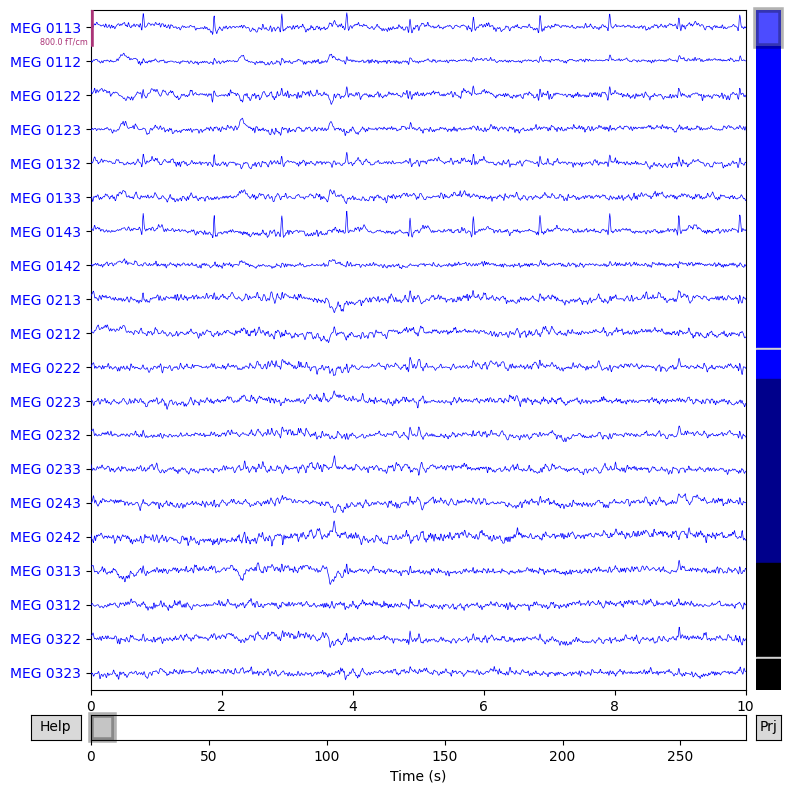

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


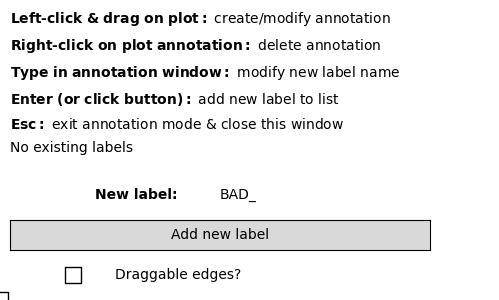

In [4]:
fig = raw.plot()
fig.fake_keypress("a")  # Simulates user pressing 'a' on the keyboard.

In [5]:
# We can also plot the events:
eog_events = mne.preprocessing.find_eog_events(raw)

# We can also plot the events:
onsets = eog_events[:, 0] / raw.info["sfreq"] - 0.25

durations = [0.5] * len(eog_events)
descriptions = ["bad blink"] * len(eog_events)
blink_annot = mne.Annotations(
    onsets, durations, descriptions, orig_time=raw.info["meas_date"]
)
# We can then add the annotations to the raw object:
raw.set_annotations(blink_annot)

Using EOG channel: EOG 061
EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG 061 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1502 samples (10.003 s)

Now detecting blinks and generating corresponding events
Found 46 significant peaks
Number of EOG events detected: 46


<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~3.2 MB, data not loaded>

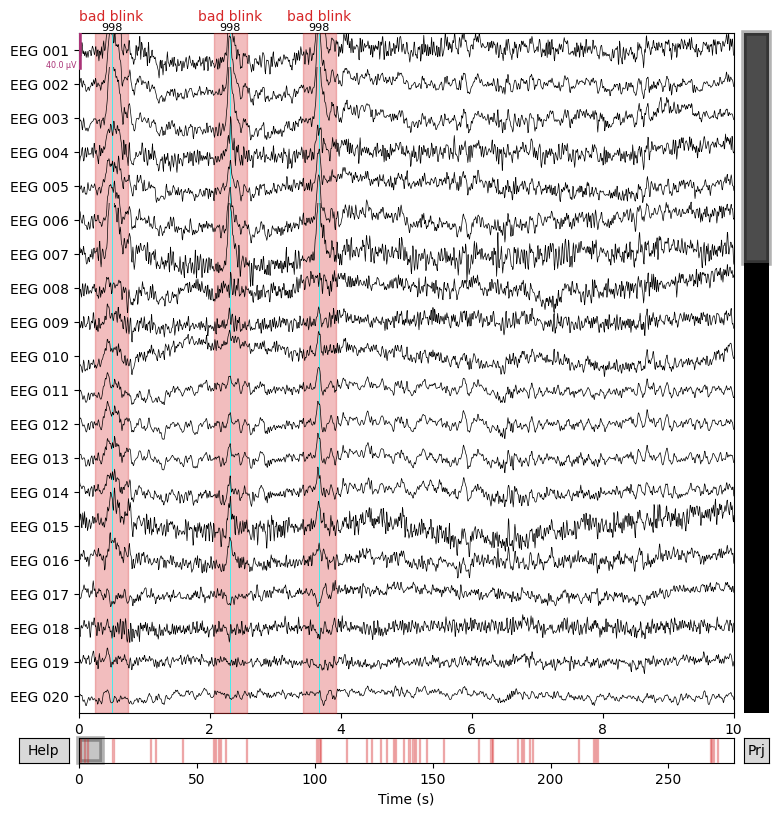

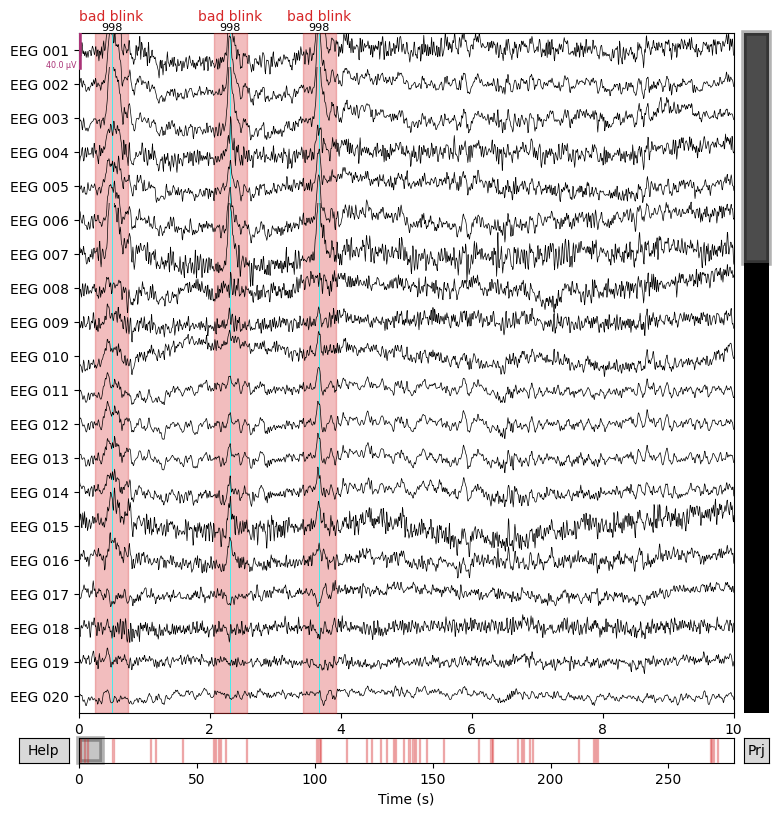

In [6]:
# We can plot the raw data with the blink annotations:
eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True)

# We can plot the raw data with the blink annotations:
raw.plot(events=eog_events, order=eeg_picks)

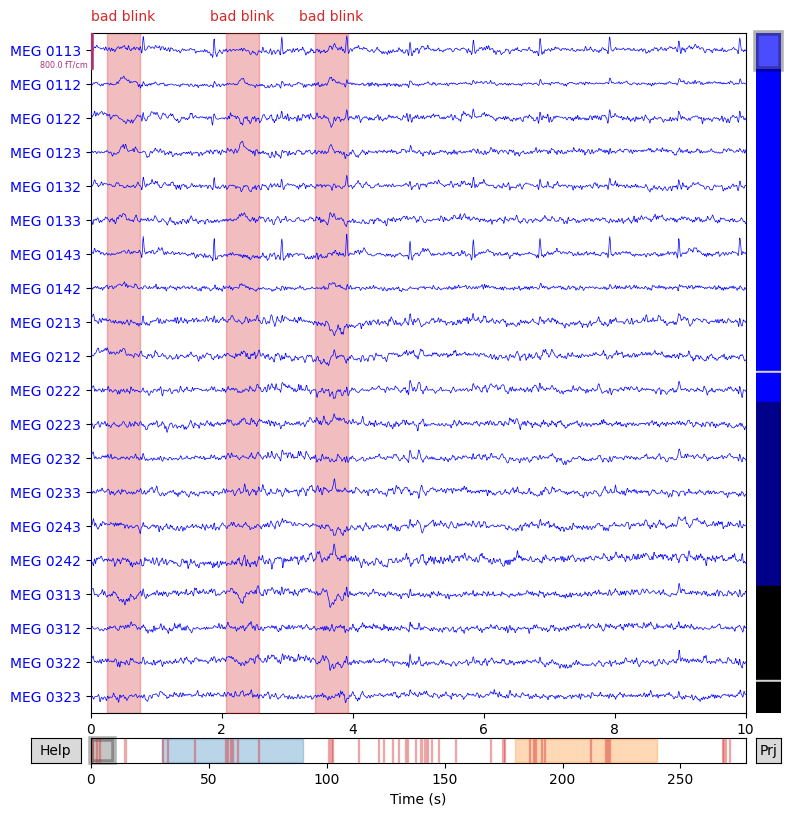

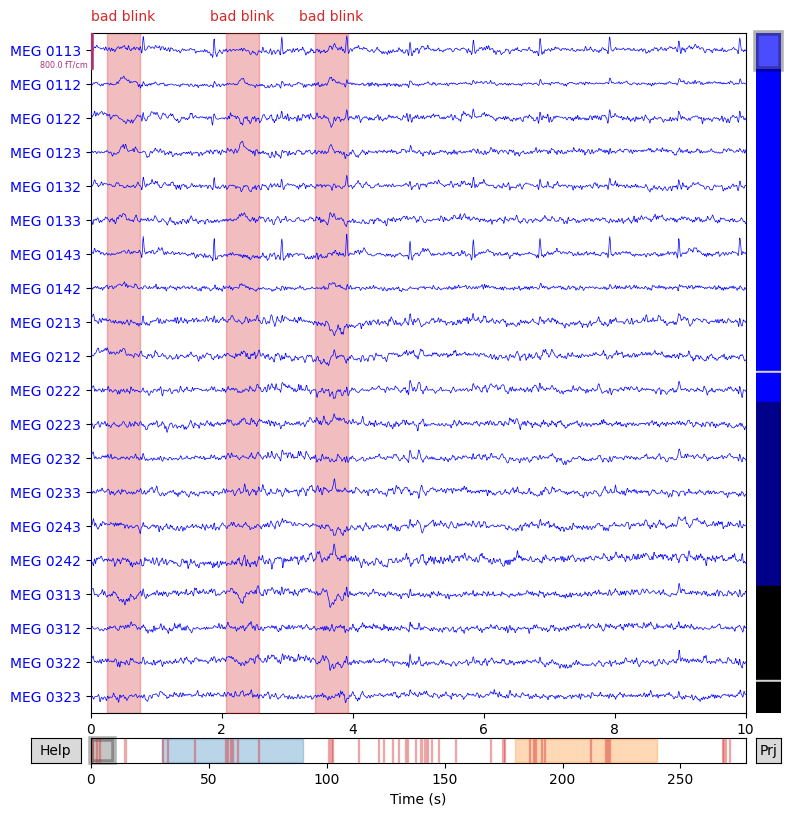

In [7]:
# We can plot the raw data with the blink annotations:
onsets = [raw.first_time + 30, raw.first_time + 180] # 30 and 180 seconds
durations = [60, 60] # 60 seconds each
descriptions = ["block_1", "block_2"] # Two different descriptions


# We can plot the raw data with the blink annotations:
block_annots = mne.Annotations(
    onset=onsets, # in seconds
    duration=durations, # in seconds
    description=descriptions, # a list of strings
    orig_time=raw.info["meas_date"], # the original time
)
raw.set_annotations(raw.annotations + block_annots)  # add to existing
raw.plot() # plot the raw data with the annotations

Ignoring annotations with descriptions starting with: bad, edge

Detected 3 break periods of >= 20 s duration:
    0.0 – 28.0 s [28.0 s]
    95.0 – 178.0 s [83.0 s]
    245.0 – 277.7 s [32.7 s]
In total, 51.7% of the data (143.7 s) have been marked as a break.



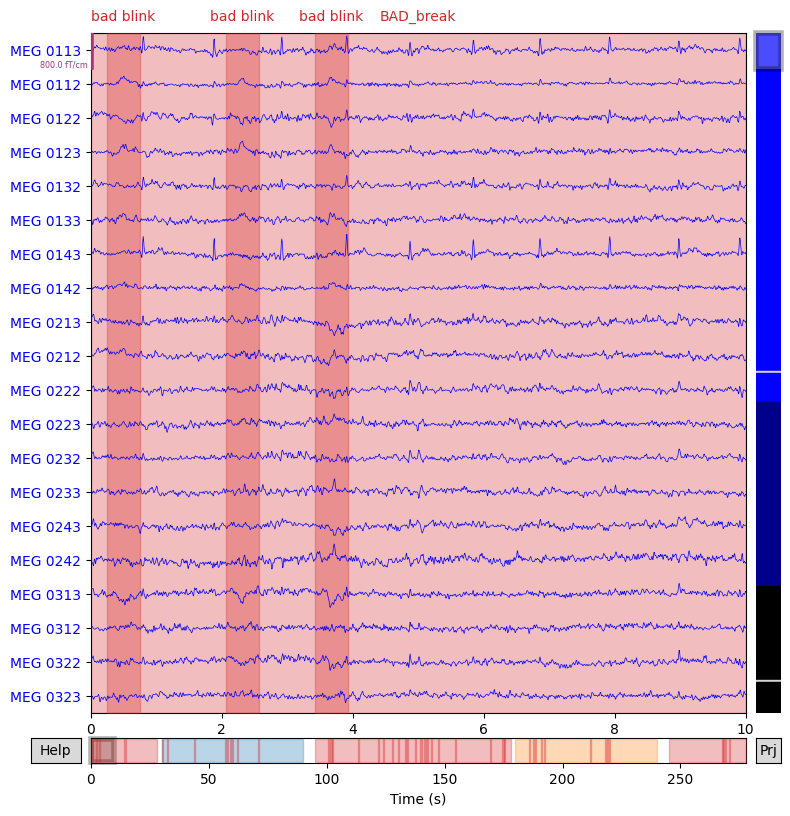

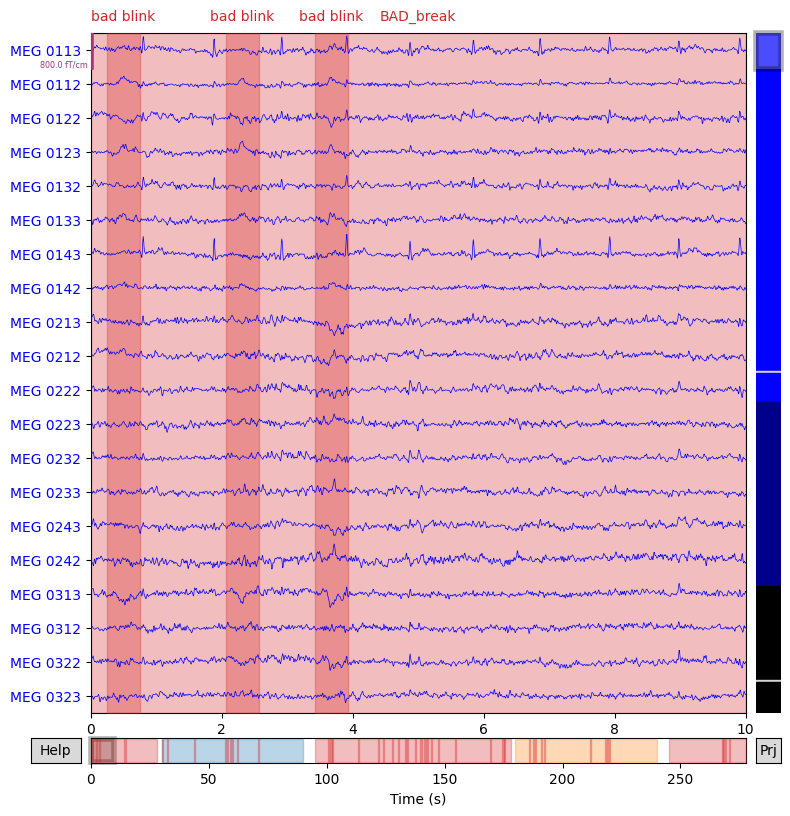

In [8]:
break_annots = mne.preprocessing.annotate_break(
    raw=raw,
    min_break_duration=20,  # consider segments of at least 20 s duration
    t_start_after_previous=5,  # start annotation 5 s after end of previous one
    t_stop_before_next=2,  # stop annotation 2 s before beginning of next one
)

raw.set_annotations(raw.annotations + break_annots)  # add to existing
raw.plot()


Detected 2 break periods of >= 25 s duration:
    0.0 – 51.4 s [51.4 s]
    185.6 – 277.7 s [92.1 s]
In total, 51.7% of the data (143.5 s) have been marked as a break.



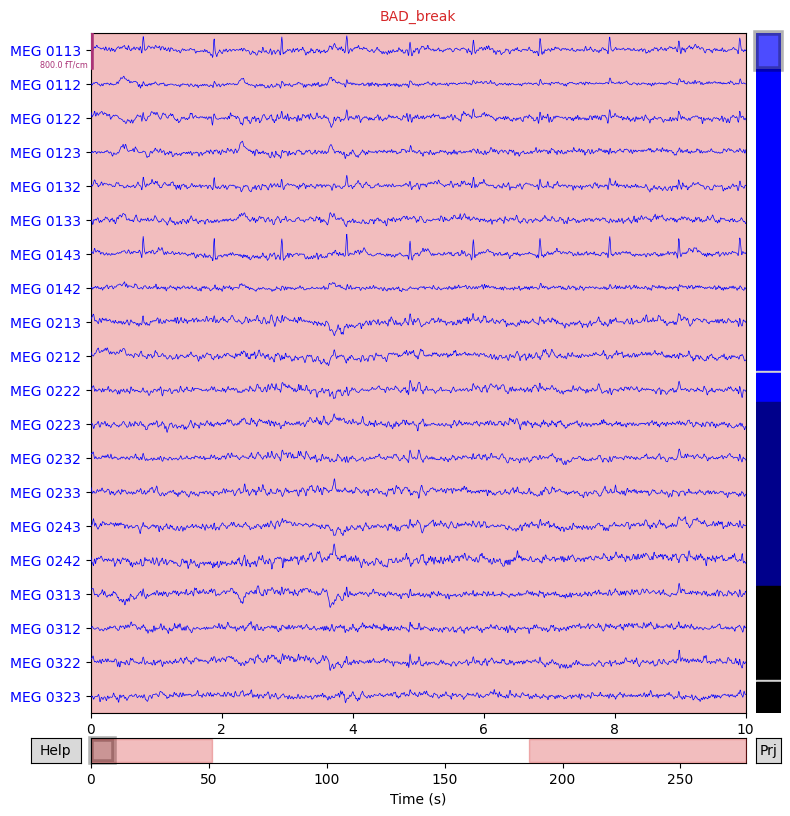

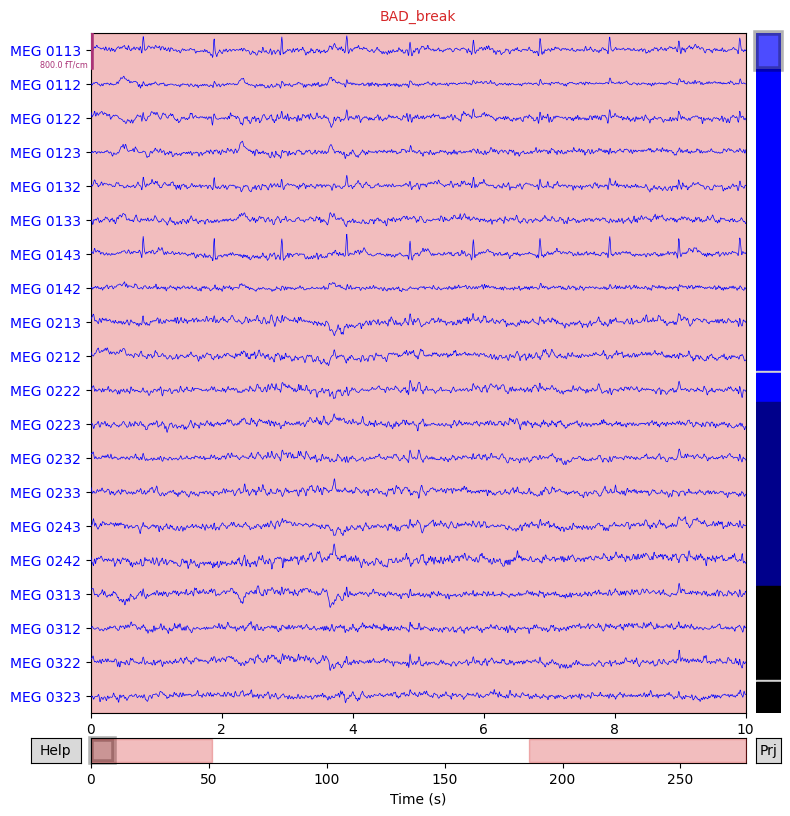

In [9]:
# only keep some button press events (code 32) for this demonstration
events_subset = events[events[:, -1] == 32]
# drop the first and last few events
events_subset = events_subset[3:-3]

break_annots = mne.preprocessing.annotate_break(
    raw=raw,
    events=events_subset,  # passing events will ignore existing annotations
    min_break_duration=25,  # pick a longer break duration this time
)

# replace existing annotations (otherwise it becomes difficult to see any
# effects in the plot!)
raw.set_annotations(break_annots)
raw.plot(events=events_subset)

In [10]:
reject_criteria = dict(
    mag=3000e-15,  # 3000 fT
    grad=3000e-13,  # 3000 fT/cm
    eeg=100e-6,  # 100 µV
    eog=200e-6,
)  # 200 µV

flat_criteria = dict(mag=1e-15, grad=1e-13, eeg=1e-6)  # 1 fT  # 1 fT/cm  # 1 µV

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 319 events and 106 original time points ...
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 007']
    Rejecting  epoch based on EEG : ['EEG 003']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003']
8 bad epochs dropped


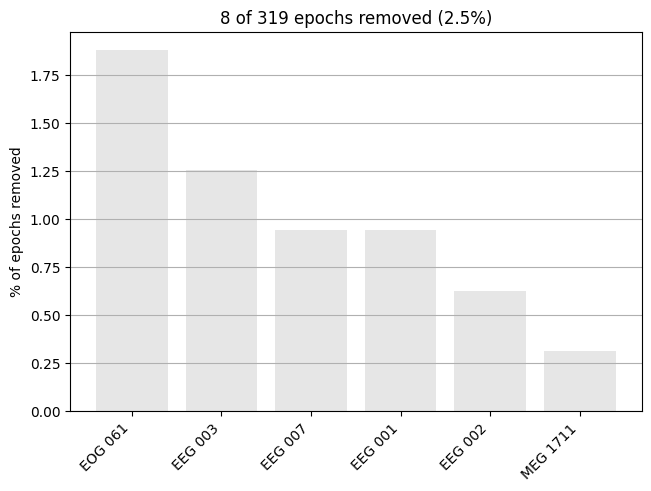

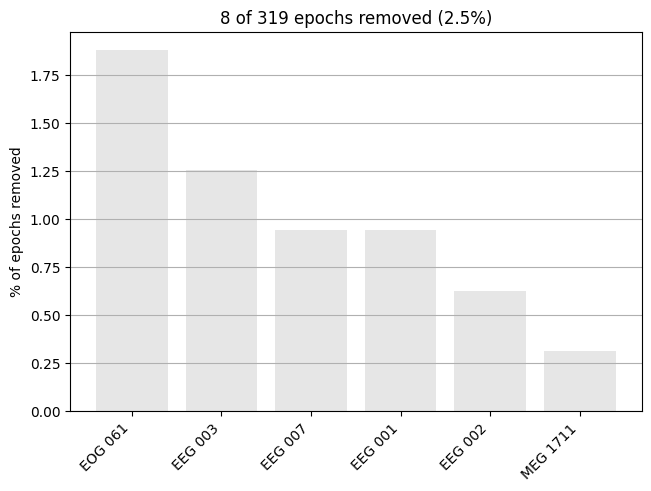

In [11]:
raw.set_annotations(blink_annot)  # restore the EOG annotations
epochs = mne.Epochs(
    raw,
    events,
    tmin=-0.2,
    tmax=0.5,
    reject_tmax=0,
    reject=reject_criteria,
    flat=flat_criteria,
    reject_by_annotation=False,
    preload=True,
)
epochs.plot_drop_log()

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 319 events and 106 original time points ...
    Rejecting  epoch based on MAG : ['MEG 1711']
39 bad epochs dropped


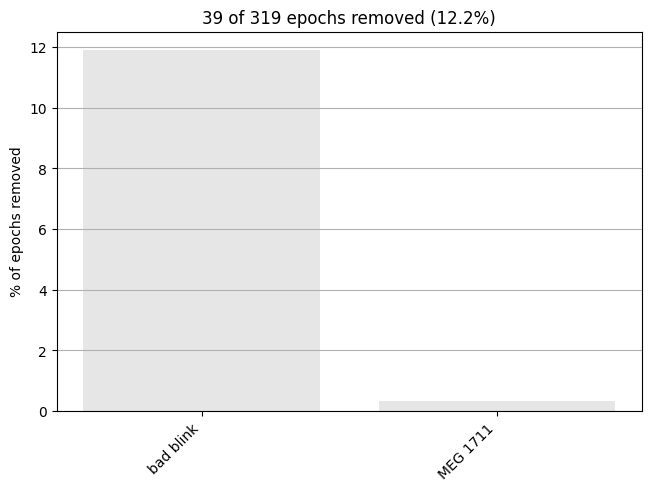

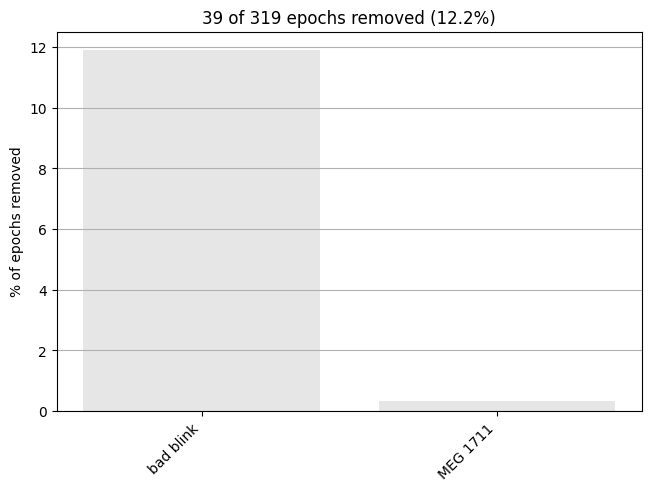

In [12]:
epochs = mne.Epochs(
    raw,
    events,
    tmin=-0.2,
    tmax=0.5,
    reject_tmax=0,
    reject=reject_criteria,
    flat=flat_criteria,
    preload=True,
)
epochs.plot_drop_log()

In [13]:
print(epochs.drop_log)

(('bad blink',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('bad blink',), ('bad blink',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('bad blink',), (), (), ('bad blink',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('bad blink',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('bad blink',), ('bad blink',), (), ('bad blink',), ('bad blink',), (), (), ('bad blink',), (), (), (), (), (), (), (), (), (), (), (), (), (), ('bad blink',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('MEG 1711',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('bad blink',), (), ('bad blink',), ('bad blink',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('bad blink',), (), (), (), (), (), (), (), (), (), (), ('bad blink',), (), (), (), (), (), (), (), (), (), ('bad blink',), (), (), ('bad bl

In [14]:
epochs.drop_bad()

In [15]:
stronger_reject_criteria = dict(
    mag=2000e-15,  # 2000 fT
    grad=2000e-13,  # 2000 fT/cm
    eeg=100e-6,  # 100 µV
    eog=100e-6,
)  # 100 µV

epochs.drop_bad(reject=stronger_reject_criteria)
print(epochs.drop_log)

    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1411', 'MEG 1421', 'MEG 1431', 'MEG 1541']
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621']
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1411', 'MEG 1421', 'MEG 1431', 'MEG 1441', 'MEG 1541', 'MEG 2621']
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621']
    Rejecting  epoch based on MAG : ['MEG 0141', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621']
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1421', 'MEG 1431']
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1411', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621']
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621']
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0141', 'MEG 1411', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621']
    Rej

# Part II - Vusialization and Analysis

Setting 3496 of 41700 (8.38%) samples to NaN, retaining 38204 (91.62%) samples.
Effective window size : 13.639 (s)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


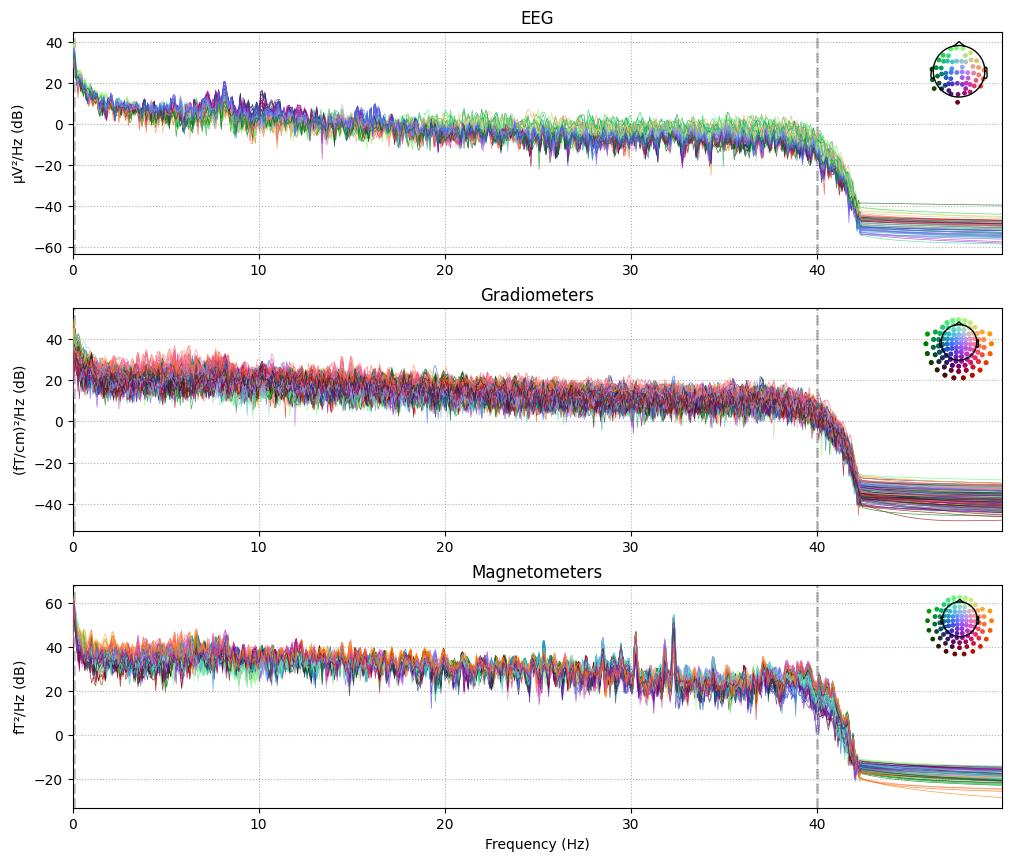

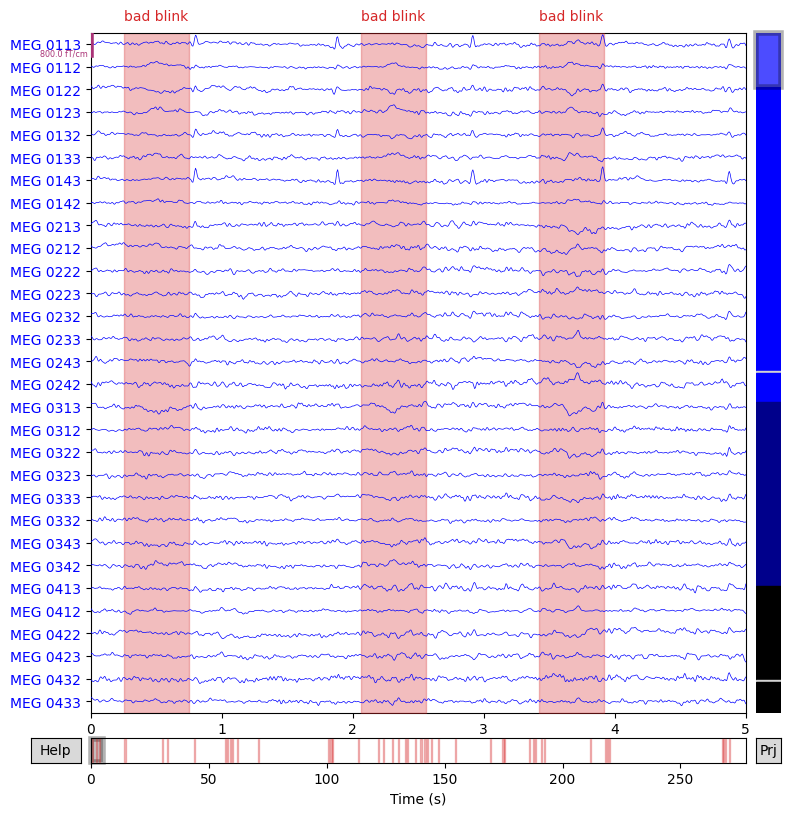

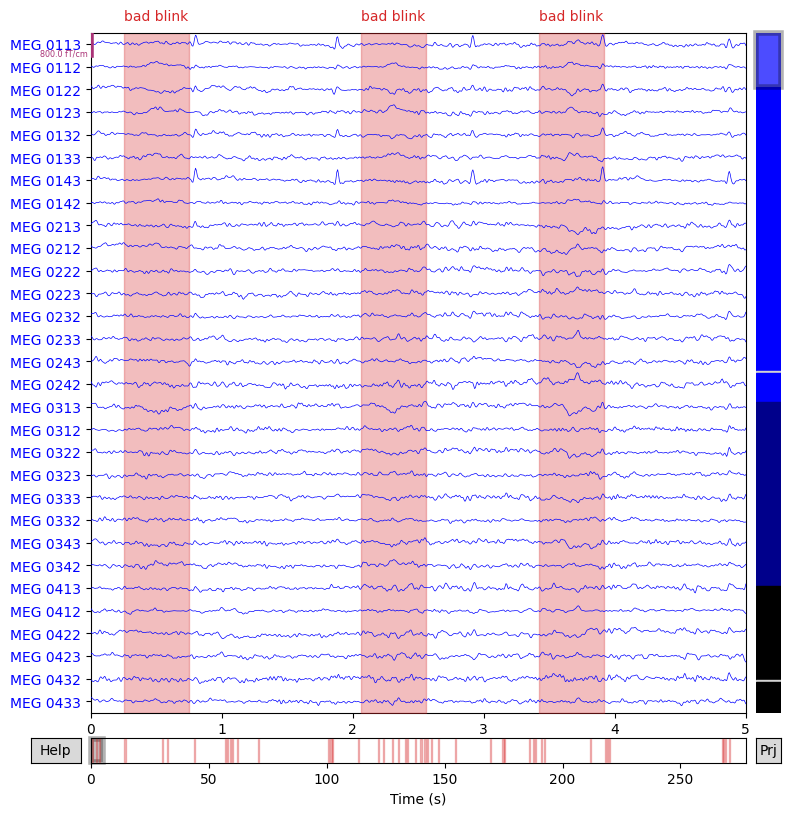

In [16]:
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads")
raw.plot(duration=5, n_channels=30)

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Omitting 3496 of 41700 (8.38%) samples, retaining 38204 (91.62%) samples.
Selecting by number: 20 components
Fitting ICA took 9.0s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated


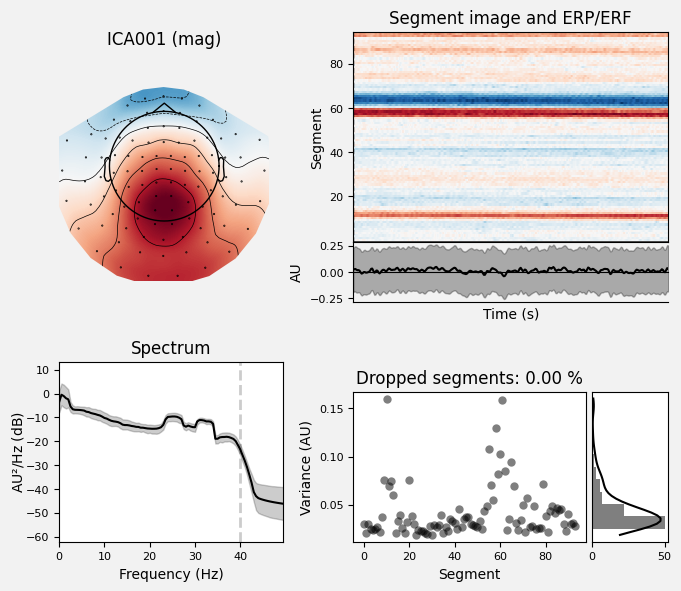

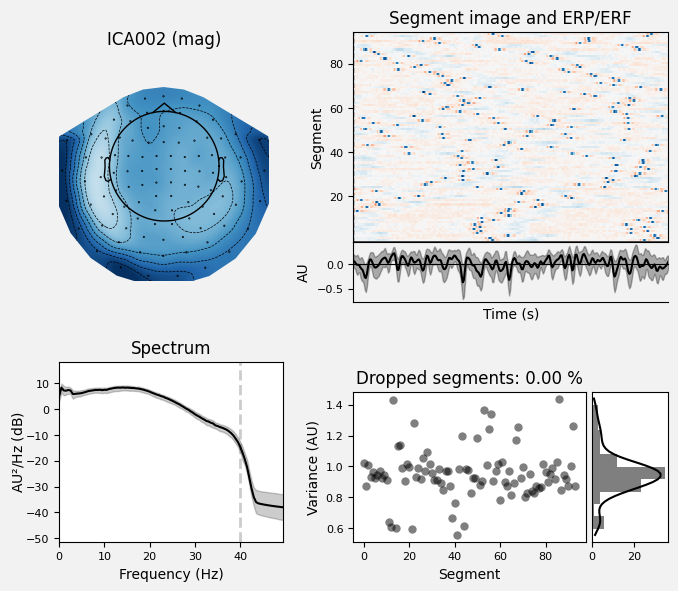

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [17]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components


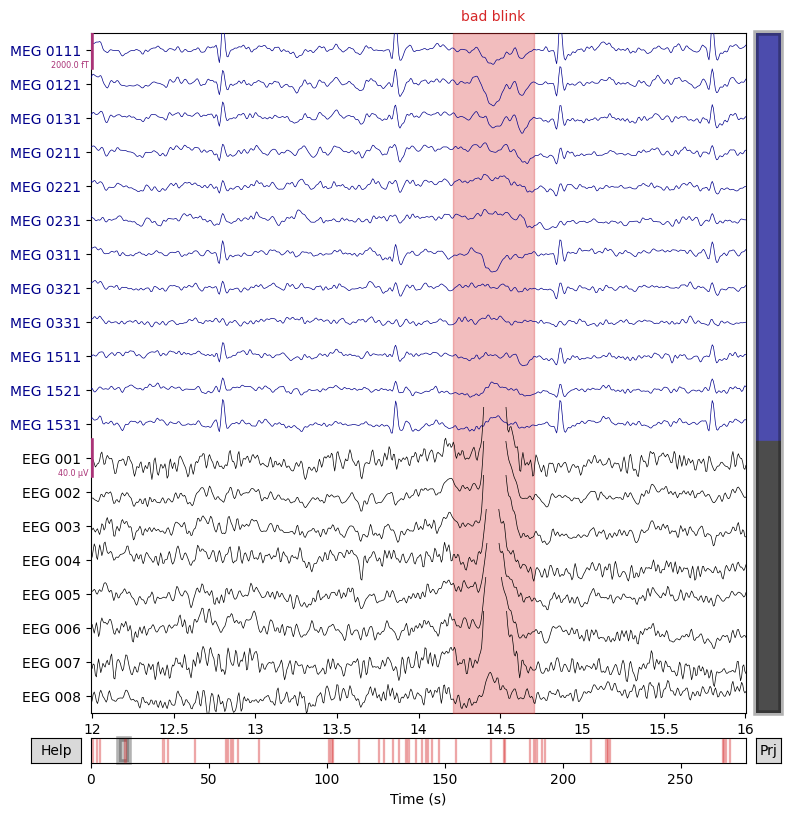

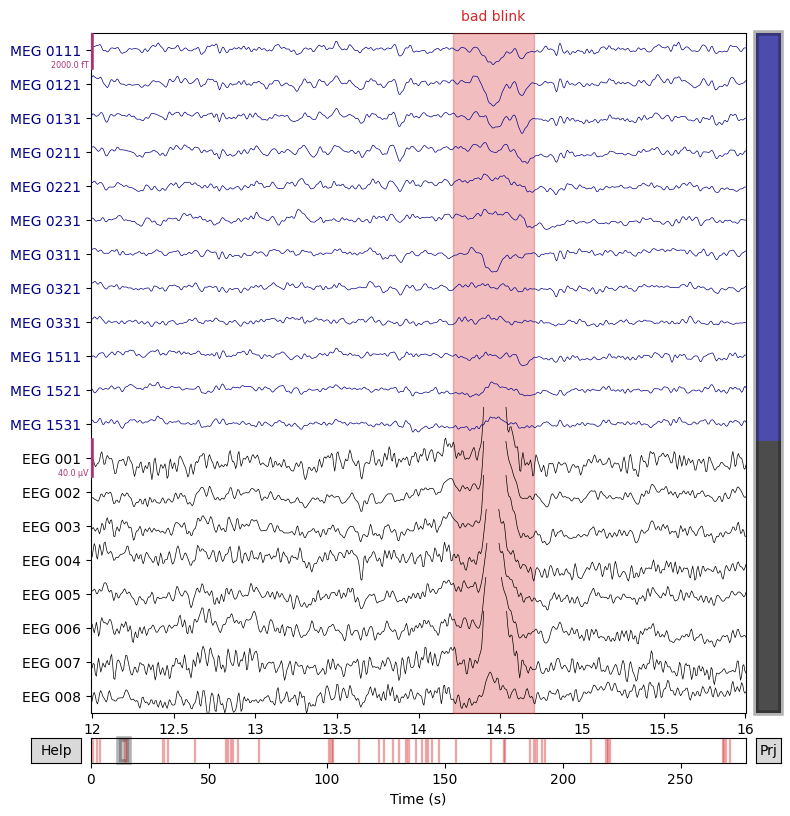

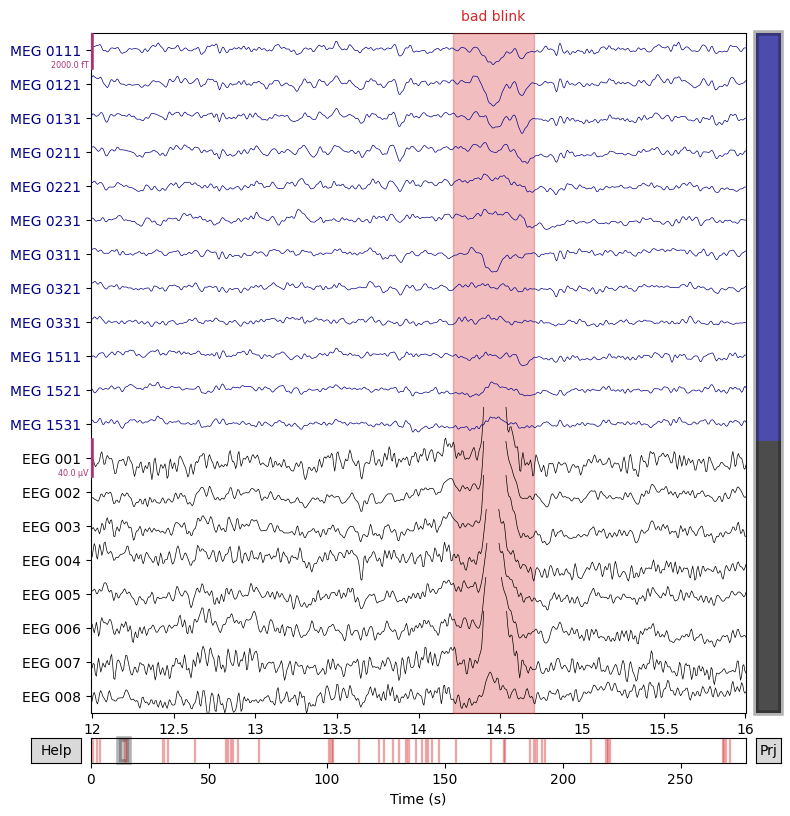

In [18]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

# show some frontal channels to clearly illustrate the artifact removal
chs = [
    "MEG 0111",
    "MEG 0121",
    "MEG 0131",
    "MEG 0211",
    "MEG 0221",
    "MEG 0231",
    "MEG 0311",
    "MEG 0321",
    "MEG 0331",
    "MEG 1511",
    "MEG 1521",
    "MEG 1531",
    "EEG 001",
    "EEG 002",
    "EEG 003",
    "EEG 004",
    "EEG 005",
    "EEG 006",
    "EEG 007",
    "EEG 008",
]
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)

In [19]:
events = mne.find_events(raw, stim_channel="STI 014")
print(events[:5])  # show the first 5

319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


In [20]:
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "smiley": 5,
    "buttonpress": 32,
}

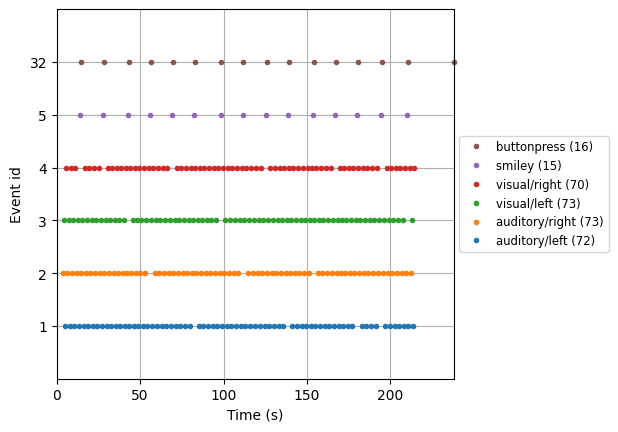

In [21]:
fig = mne.viz.plot_events(
    events, event_id=event_dict, sfreq=raw.info["sfreq"], first_samp=raw.first_samp
)

In [22]:
reject_criteria = dict(
    mag=4000e-15,  # 4000 fT
    grad=4000e-13,  # 4000 fT/cm
    eeg=150e-6,  # 150 µV
    eog=250e-6,
)  # 250 µV

In [23]:
epochs = mne.Epochs(
    raw,
    events,
    event_id=event_dict,
    tmin=-0.2,
    tmax=0.5,
    reject=reject_criteria,
    preload=True,
)

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 319 events and 106 original time points ...
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
68 bad epochs dropped


In [24]:
conds_we_care_about = ["auditory/left", "auditory/right", "visual/left", "visual/right"]
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
aud_epochs = epochs["auditory"]
vis_epochs = epochs["visual"]
del raw, epochs  # free up memory

Dropped 22 epochs: 35, 38, 87, 99, 100, 101, 102, 147, 151, 154, 155, 157, 164, 165, 166, 167, 198, 203, 208, 212, 217, 218


Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated


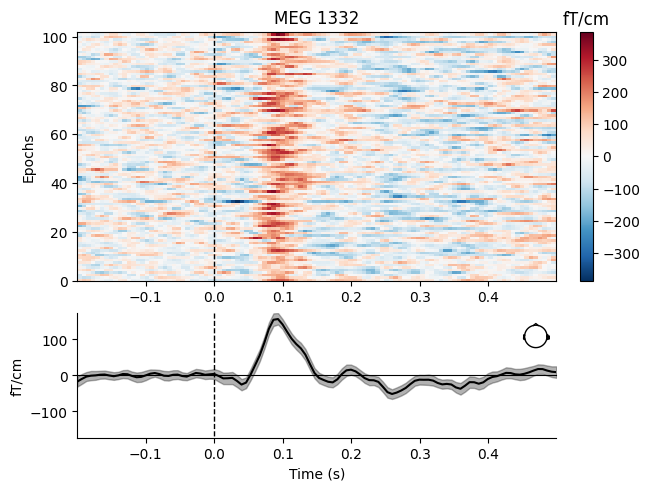

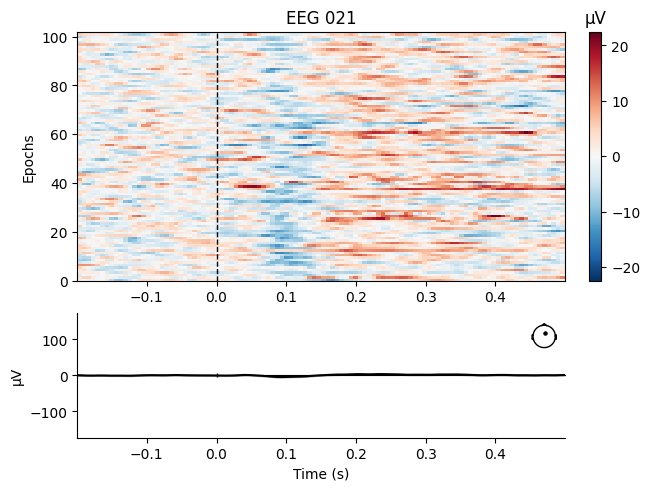

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [25]:
aud_epochs.plot_image(picks=["MEG 1332", "EEG 021"])

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    6.1s


Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
No baseline correction applied


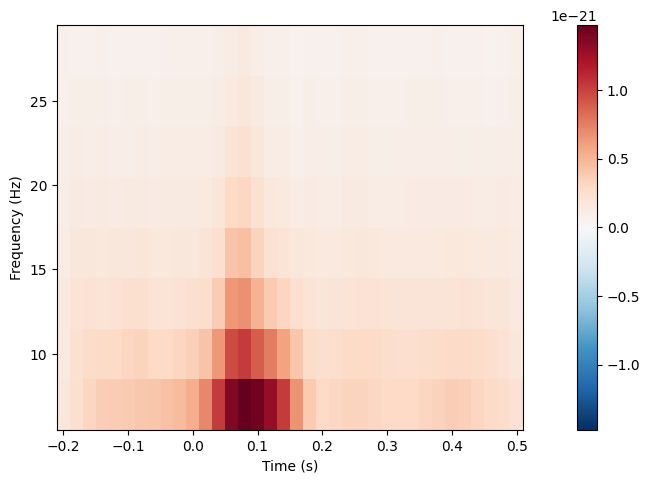

[<Figure size 640x480 with 2 Axes>]

In [28]:
frequencies = np.arange(7, 30, 3)
power = mne.time_frequency.tfr_morlet(
    aud_epochs, n_cycles=2, return_itc=False, freqs=frequencies, decim=3
)
power.plot(["MEG 1332"])

Multiple channel types selected, returning one figure per type.
combining channels using "gfp"
combining channels using "gfp"


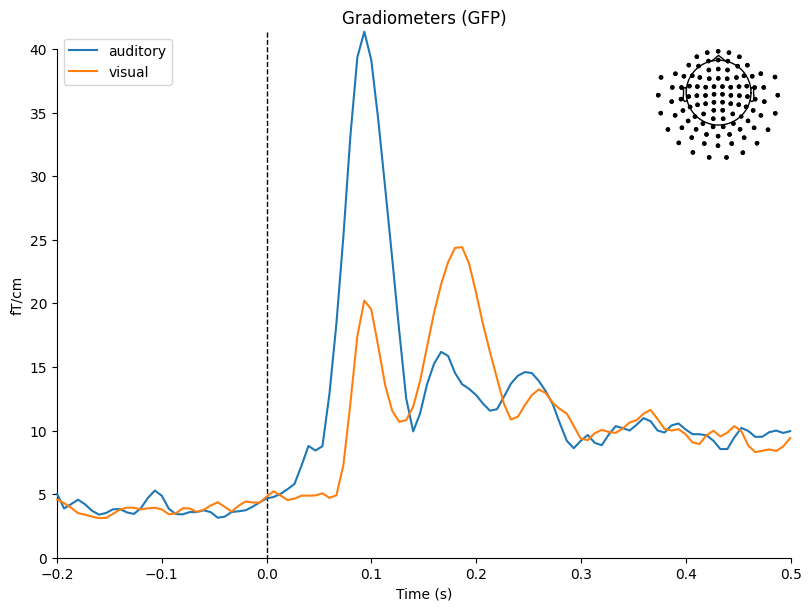

combining channels using "gfp"
combining channels using "gfp"


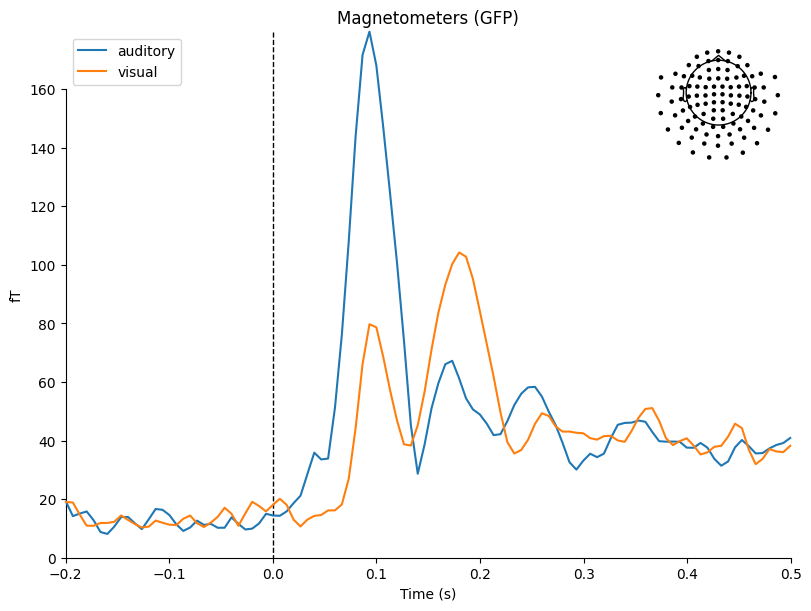

combining channels using "gfp"
combining channels using "gfp"


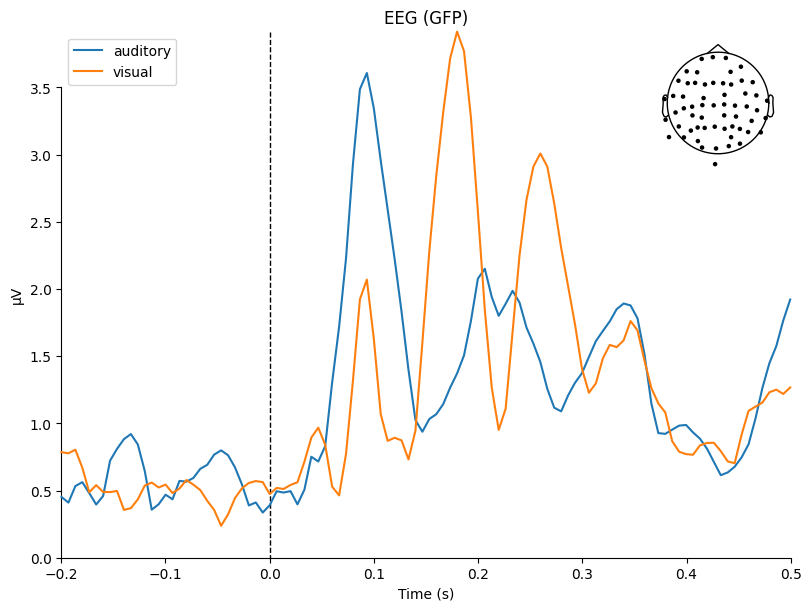

[<Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>]

In [29]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(
    dict(auditory=aud_evoked, visual=vis_evoked),
    legend="upper left",
    show_sensors="upper right",
)

Projections have already been applied. Setting proj attribute to True.
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


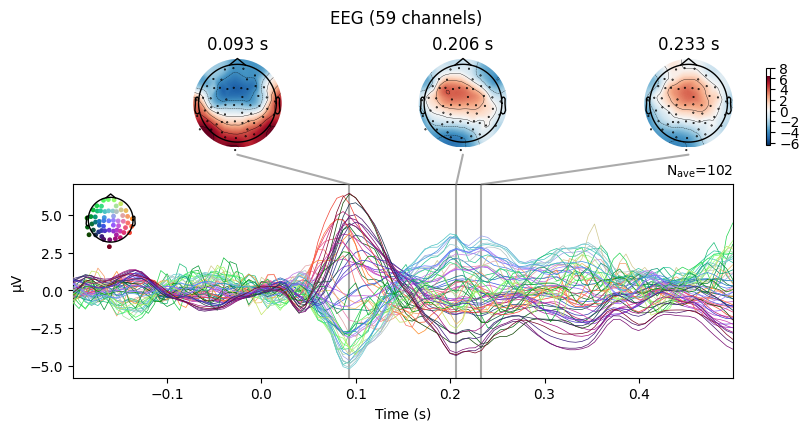

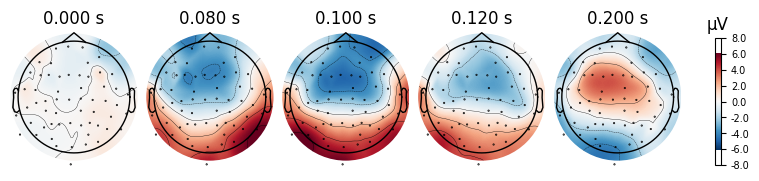

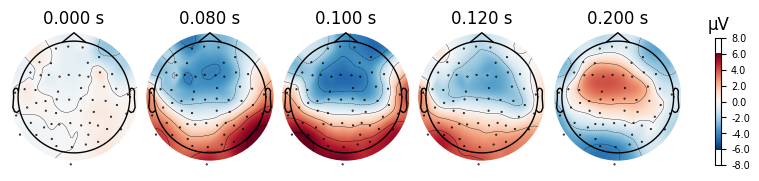

In [30]:
aud_evoked.plot_joint(picks="eeg")
aud_evoked.plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2], ch_type="eeg")

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


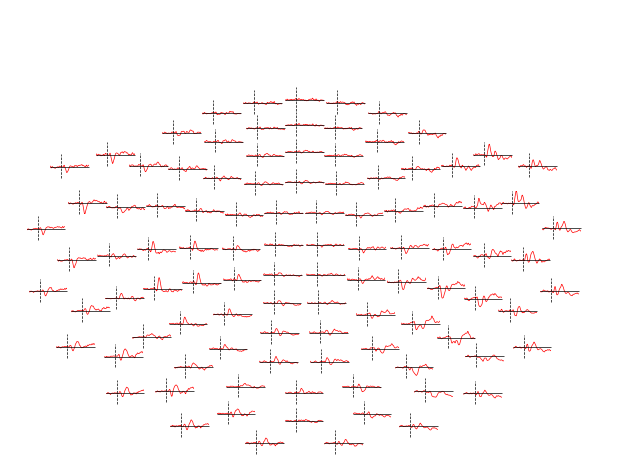

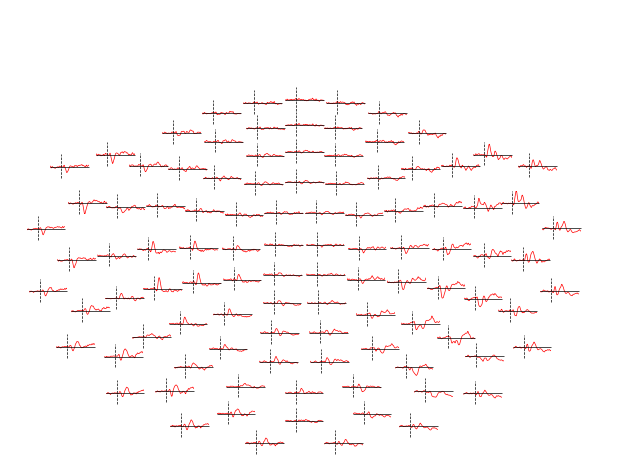

In [31]:
evoked_diff = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1])
evoked_diff.pick(picks="mag").plot_topo(color="r", legend=False)

In [35]:
# load inverse operator
inverse_operator_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis-meg-oct-6-meg-inv.fif"
)
inv_operator = mne.minimum_norm.read_inverse_operator(inverse_operator_file)
# set signal-to-noise ratio (SNR) to compute regularization parameter (λ²)
snr = 3.0
lambda2 = 1.0 / snr**2
# generate the source time course (STC)
stc = mne.minimum_norm.apply_inverse(
    vis_evoked, inv_operator, lambda2=lambda2, method="MNE"
)  # or dSPM, sLORETA, eLORETA

Reading inverse operator decomposition from /Users/tino/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing pat

In [39]:
# path to subjects' MRI files
subjects_dir = sample_data_folder / "subjects"
# plot the STC
stc.plot(
    initial_time=0.1, hemi="split", views=["lat", "med"], subjects_dir=subjects_dir
)

Using control points [8.75897208e-11 1.07817056e-10 4.77238544e-10]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
